In [66]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
conn = sqlite3.connect('../db/sensor_data.sqlite')
table = "full_flat_sensor_data"  # 테이블명 , 언젠가 바꿀 수도..
query = "SELECT * FROM " + table 
df = pd.read_sql_query(query, conn)

In [5]:
df1 = df[df['device_id']=='agv01']
df1.head()

,id,device_id,device_manufacturer,device_name,dust_sensor_manufacturer,dust_sensor_name,temp_sensor_manufacturer,temp_sensor_name,overcurrent_sensor_manufacturer,overcurrent_sensor_name,...,annotation_state,ex_temperature_value,ex_temperature_unit,ex_temperature_trend,ex_humidity_value,ex_humidity_unit,ex_humidity_trend,ex_illuminance_value,ex_illuminance_unit,ex_illuminance_trend
0,1,agv01,B,B1,S01,S02,S09,S10,S17,S18,...,0,25.0,℃,1,31.0,%,1,160.0,lux,1
1,2,agv01,B,B1,S01,S02,S09,S10,S17,S18,...,0,26.0,℃,1,29.0,%,1,153.0,lux,1
2,3,agv01,B,B1,S01,S02,S09,S10,S17,S18,...,0,26.0,℃,1,28.0,%,1,159.0,lux,1
3,4,agv01,B,B1,S01,S02,S09,S10,S17,S18,...,0,26.0,℃,1,28.0,%,1,155.0,lux,1
4,5,agv01,B,B1,S01,S02,S09,S10,S17,S18,...,0,25.0,℃,1,27.0,%,1,155.0,lux,1


PM10_value
PM2_5_value
PM1_0_value
NTC_value
CT1_value
CT2_value
CT3_value
CT4_value

ex_temperature_value
ex_humidity_value
ex_illuminance_value

In [30]:
df1_sensor = df1[['PM10_value',
'PM2_5_value',
'PM1_0_value',
'NTC_value',
'CT1_value',
'CT2_value',
'CT3_value',
'CT4_value',
'ex_temperature_value',
'ex_humidity_value',
'ex_illuminance_value']]

df1_sensor[['CT1_value',
'CT2_value',
'CT3_value',
'CT4_value']].describe()

,CT1_value,CT2_value,CT3_value,CT4_value
count,2527.000000,2527.000000,2527.000000,2527.000000
mean,1.889798,92.320451,52.398943,22.106296
std,0.143577,37.962298,15.684071,15.006102
min,1.450000,74.390000,48.950000,18.950000
25%,1.780000,74.900000,49.920000,19.900000
50%,1.880000,75.200000,49.970000,19.950000
75%,2.010000,86.610000,50.030000,20.010000
max,2.300000,273.530000,243.150000,216.400000


In [56]:
df1.collection_date.value_counts()

collection_date
09-02    722
09-03    722
10-27    722
09-01    361
Name: count, dtype: int64

# 1. 이상 전류 발생률

정의: 기준치를 초과한 전류 측정 비율

공식: (기준전류 초과 횟수) / (전체 측정 횟수) x 100

그런데 기준 전류에서 기준은 어떻게 설정할까? (난 3으로 함)
Six Sigma 규칙 (정규분포 가정)
기준: 평균 ± k × 표준편차

k = 2 → 약 95% 포함

k = 3 → 약 99.7% 포함

실무에서는 3σ를 이상 탐지 기준으로 가장 많이 사용함.
이유는 정상 데이터 기준으로 0.3% 이내만 이상으로 판단하므로 경고 탐지에서 과잉 민감하지 않음

✔️ 예외:

민감한 시스템(의료, 반도체 등)은 2σ 사용

완전한 이상 징후만 탐지해야 하는 경우는 3.5~4σ까지도 씀

In [62]:
def abnormal_current(df, std_scale=3, state_col='annotation_state'):
    """
    전류 센서 기준으로 이상전류 발생률 계산 + state와의 관계 분석

    :df: 입력 데이터프레임 (CT센서 및 state 포함)
    :std_scale: 기준 설정에 사용할 표준편차 배수 (기본: 2)
    :state_col: 장비 상태 컬럼명
    
    결과: 
    (1) 이상전류 발생률 dict, (2) 이상판정 열이 추가된 DataFrame, (3) 상태별 이상비율 교차표
    """
    
    df = df.copy()
    
    # 1. 전류 센서 컬럼 자동 탐지
    ct_columns = [col for col in df.columns if col.startswith("CT") and df[col].dtype != 'O']
    if not ct_columns:
        raise ValueError("CT로 시작하는 전류 센서 컬럼이 존재하지 않음.")
    
    # 2. 기준 설정 (mean + std_scale(default=3)*std)
    thresholds = {}
    for col in ct_columns:
        mean = df[col].mean()
        std = df[col].std()
        thresholds[col] = mean + std_scale * std
    
    # 3. 이상 여부 판별 컬럼 생성
    for col in ct_columns:
        abnormal_col = f"{col}_abnormal"
        df[abnormal_col] = df[col] > thresholds[col]
    
    # 4. 이상전류 발생률 계산 (4개의 전류 센서(CT1~CT4) 중 하나라도 이상이면, 해당 row 전체를 "이상전류로 구분")
    abnormal_rates = {
        col: float(round(df[f"{col}_abnormal"].mean() * 100, 3))
        for col in ct_columns
    }
    
    # 5. 상태별 이상비율 교차표
    if state_col in df.columns:
        df['any_abnormal_current'] = df[[f"{col}_abnormal" for col in ct_columns]].any(axis=1)
        cross_tab = pd.crosstab(df[state_col], df['any_abnormal_current'], normalize='index') * 100
        cross_tab.columns = ['정상 전류 비율 (%)', '이상 전류 비율 (%)']
    else:
        cross_tab = None

    return abnormal_rates, df, cross_tab


In [63]:
rates, df_with_flags, state_relation = abnormal_current(df1, 3)

print("📊 이상전류 발생률 (%)")
print(rates)

print("\n📈 상태별 이상전류 비율")
print(state_relation)

📊 이상전류 발생률 (%)
{'CT1_value': 0.0, 'CT2_value': 3.601, 'CT3_value': 1.741, 'CT4_value': 1.622}

📈 상태별 이상전류 비율
                  정상 전류 비율 (%)  이상 전류 비율 (%)
annotation_state                            
0                   100.000000      0.000000
1                   100.000000      0.000000
2                    95.437956      4.562044
3                    30.000000     70.000000


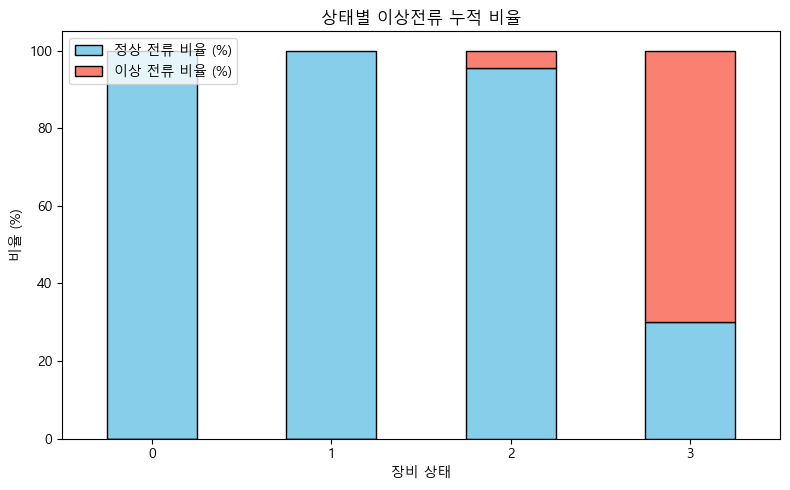

In [67]:
def plot_state_abnormal_stacked(state_relation):
    ax = state_relation.plot(kind='bar', stacked=True, figsize=(8, 5),
                             color=['skyblue', 'salmon'], edgecolor='black')
    plt.title('상태별 이상전류 누적 비율')
    plt.ylabel('비율 (%)')
    plt.xlabel('장비 상태')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_state_abnormal_stacked(state_relation)

# 